(200, 2) (200,)


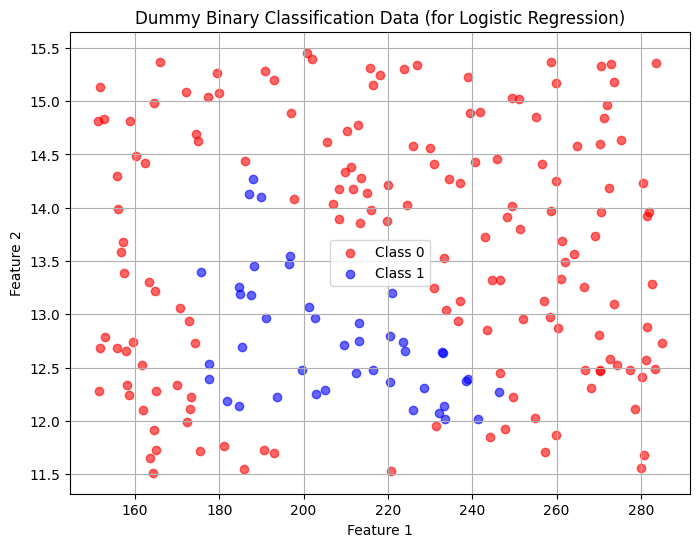

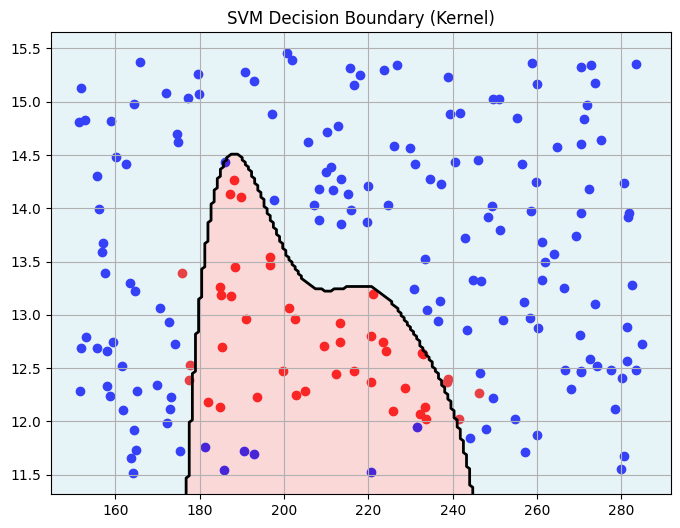

In [1]:
import numpy as np
from matplotlib import pyplot as plt

def load_coffee_data():
    """ Creates a coffee roasting data set.
        roasting duration: 12-15 minutes is best
        temperature range: 175-260C is best
    """
    rng = np.random.default_rng(2)
    X = rng.random(400).reshape(-1,2)
    X[:,1] = X[:,1] * 4 + 11.5          # 12-15 min is best
    X[:,0] = X[:,0] * (285-150) + 150  # 350-500 F (175-260 C) is best
    Y = np.zeros(len(X))
    
    i=0
    for t,d in X:
        y = -3/(260-175)*t + 21
        if (t > 175 and t < 260 and d > 12 and d < 15 and d<=y ):
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1

    return (X, Y)

X,y = load_coffee_data()
print(X.shape, y.shape)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X[y.flatten() == 0][:, 0], X[y.flatten() == 0][:, 1], color="red", label="Class 0", alpha=0.6)
plt.scatter(X[y.flatten() == 1][:, 0], X[y.flatten() == 1][:, 1], color="blue", label="Class 1", alpha=0.6)
plt.title("Dummy Binary Classification Data (for Logistic Regression)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

# --- Kernels ---
def linear_kernel(X1, X2):
    return np.dot(X1, X2.T)

def rbf_kernel(X1, X2, gamma=0.5):
    sq_dists = np.sum(X1**2, axis=1).reshape(-1, 1) + \
               np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return np.exp(-gamma * sq_dists)

def soft_margin_svm(X, y, C=1.0, use_kernel=False, kernel_fn=rbf_kernel, gamma=0.5):
    n_samples = X.shape[0]

    # Compute kernel or linear Gram matrix
    if use_kernel:
        K = kernel_fn(X, X, gamma=gamma) if kernel_fn == rbf_kernel else kernel_fn(X, X)
    else:
        K = linear_kernel(X, X)

    # QP parameters
    P = matrix(np.outer(y, y) * K)
    q = matrix(-np.ones(n_samples))
    G = matrix(np.vstack([-np.eye(n_samples), np.eye(n_samples)]))
    h = matrix(np.hstack([np.zeros(n_samples), np.ones(n_samples) * C]))
    A = matrix(y.reshape(1, -1).astype(float))
    b = matrix(0.0)

    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b)
    alpha = np.ravel(sol['x'])

    sv = alpha > 1e-5
    alpha_sv = alpha[sv]
    X_sv = X[sv]
    y_sv = y[sv]

    if use_kernel:
        K_sv = kernel_fn(X_sv, X_sv, gamma=gamma) if kernel_fn == rbf_kernel else kernel_fn(X_sv, X_sv)
        b = np.mean([y_sv[i] - np.sum(alpha_sv * y_sv * K_sv[i]) for i in range(len(alpha_sv))])
        return alpha_sv, X_sv, y_sv, b, use_kernel, kernel_fn, gamma
    else:
        # Linear case
        w = np.sum(alpha_sv[:, np.newaxis] * y_sv[:, np.newaxis] * X_sv, axis=0)
        b = np.mean([y_k - np.dot(w, x_k) for x_k, y_k in zip(X_sv, y_sv)])
        return w, b, alpha, sv, use_kernel

def predict(X_test, model):
    if model[-1]:  # use_kernel == True
        alpha_sv, X_sv, y_sv, b, _, kernel_fn, gamma = model
        K = kernel_fn(X_test, X_sv, gamma=gamma) if kernel_fn == rbf_kernel else kernel_fn(X_test, X_sv)
        return np.sign(np.dot(K, alpha_sv * y_sv) + b)
    else:
        w, b, _, _, _ = model
        return np.sign(np.dot(X_test, w) + b)

def plot_decision_boundary(X, y, model):
    plt.figure(figsize=(8, 6))
    
    # Plot data points
    for i in range(len(y)):
        plt.scatter(X[i, 0], X[i, 1], c='r' if y[i] == 1 else 'b', marker='o')

    ax = plt.gca()
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(*xlim, 200), np.linspace(*ylim, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = predict(grid, model).reshape(xx.shape)

    # Fill class regions with color
    plt.contourf(xx, yy, Z, levels=[-1, 0, 1], colors=['lightblue', 'lightcoral'], alpha=0.3)

    # Draw only the decision boundary (f(x) = 0)
    plt.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)

    plt.title("SVM Decision Boundary" + (" (Kernel)" if model[-1] else " (Linear)"))
    plt.grid(True)
    plt.show()

y = np.where(y == 0, -1, 1)

model = soft_margin_svm(X, y, C=100.0, use_kernel=True, kernel_fn=rbf_kernel, gamma=0.002)
plot_decision_boundary(X, y, model)